In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 1. 설정 및 하이퍼파라미터
# -----------------------------------------------------------------------------
BATCH_SIZE = 4
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_CLASSES = 8 # KITTI 클래스 수
IMAGE_SIZE = (384, 1280) # (H, W) - 입력 이미지 크기

# !!! 사용자 설정: KITTI Object Detection 데이터셋의 'training' 폴더 경로를 지정해주세요.
DATASET_ROOT = "C:/Users/user/Desktop/data/training"

IMAGE_DIR = os.path.join(DATASET_ROOT, 'image_2')
LABEL_DIR = os.path.join(DATASET_ROOT, 'label_2')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# -----------------------------------------------------------------------------
# 2. 유틸리티 함수 (Box Utils & Decoding)
# -----------------------------------------------------------------------------
def convert_to_corners(boxes):
    """(cx, cy, w, h) -> (x1, y1, x2, y2)"""
    return torch.cat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        dim=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = torch.maximum(boxes1_corners[:, None, :2], boxes2_corners[None, :, :2])
    rd = torch.minimum(boxes1_corners[:, None, 2:], boxes2_corners[None, :, 2:])
    intersection = torch.maximum(torch.tensor(0.0, device=boxes1.device), rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = torch.maximum(
        boxes1_area[:, None] + boxes2_area[None, :] - intersection_area, 
        torch.tensor(1e-8, device=boxes1.device)
    )
    return torch.clamp(intersection_area / union_area, min=0.0, max=1.0)

def decode_box(anchors, box_regression, variance=[0.1, 0.1, 0.2, 0.2]):
    """
    모델의 Regression Output을 실제 박스 좌표(cx, cy, w, h)로 변환
    anchors: (N, 4)
    box_regression: (N, 4) - 모델 예측값 (deltas)
    """
    # t_x, t_y, t_w, t_h
    t_x = box_regression[:, 0]
    t_y = box_regression[:, 1]
    t_w = box_regression[:, 2]
    t_h = box_regression[:, 3]
    
    # Anchor: c_xa, c_ya, w_a, h_a
    wa = anchors[:, 2]
    ha = anchors[:, 3]
    cxa = anchors[:, 0]
    cya = anchors[:, 1]
    
    # Decode
    cx = t_x * wa * variance[0] + cxa
    cy = t_y * ha * variance[1] + cya
    w = torch.exp(t_w * variance[2]) * wa
    h = torch.exp(t_h * variance[3]) * ha
    
    return torch.stack([cx, cy, w, h], dim=1)

In [3]:
# -----------------------------------------------------------------------------
# 3. Anchor Box 클래스
# -----------------------------------------------------------------------------
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = torch.sqrt(torch.tensor(area / ratio))
                anchor_width = area / anchor_height
                dims = torch.tensor([anchor_width, anchor_height]).view(1, 1, 2)
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(torch.stack(anchor_dims, dim=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = torch.arange(feature_width, dtype=torch.float32) + 0.5
        ry = torch.arange(feature_height, dtype=torch.float32) + 0.5
        centers = torch.stack(torch.meshgrid(rx, ry, indexing='xy'), dim=-1)
        centers = (centers * self._strides[level - 3]).unsqueeze(2)
        centers = centers.expand(-1, -1, self._num_anchors, 2)
        dims = self._anchor_dims[level - 3].expand(feature_height, feature_width, -1, -1)
        anchors = torch.cat([centers, dims], dim=-1)
        return anchors.reshape(-1, 4)

    def get_anchors(self, image_height, image_width):
        """이미지 크기에 맞는 모든 앵커를 생성하고 반환 (cx, cy, w, h)"""
        anchors = [
            self._get_anchors(
                int(np.ceil(image_height / 2 ** i)),
                int(np.ceil(image_width / 2 ** i)),
                i,
            )
            for i in range(3, 8) # P3 to P7
        ]
        return torch.cat(anchors, dim=0)

In [4]:
# -----------------------------------------------------------------------------
# 4. Label Encoder 클래스
# -----------------------------------------------------------------------------
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)

    def encode_batch(self, batch_images, batch_gt_boxes, batch_cls_ids):
        image_shape = batch_images.shape
        anchor_boxes = self._anchor_box.get_anchors(image_shape[2], image_shape[3]).to(batch_images.device)
        
        batch_cls_targets = []
        batch_box_targets = []
        
        for i in range(image_shape[0]):
            gt_boxes = batch_gt_boxes[i]
            cls_ids = batch_cls_ids[i].float()
            
            if gt_boxes.shape[0] > 0:
                iou_matrix = compute_iou(anchor_boxes, gt_boxes)
                max_iou, matched_gt_idx = torch.max(iou_matrix, dim=1)
                
                positive_mask = max_iou >= 0.5
                negative_mask = max_iou < 0.4
                ignore_mask = ~(positive_mask | negative_mask)
                
                matched_gt_boxes = gt_boxes[matched_gt_idx]
                matched_gt_cls_ids = cls_ids[matched_gt_idx]
                
                # Box Target 계산
                box_target = torch.cat(
                    [
                        (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                        torch.log(torch.max(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:], torch.tensor(1e-8, device=gt_boxes.device))),
                    ],
                    dim=-1,
                )
                box_target = box_target / self._box_variance.to(box_target.device)
                
                # Class Target 계산 (Positive: class_id, Negative: -1, Ignore: -2)
                cls_target = torch.where(positive_mask, matched_gt_cls_ids, torch.tensor(-1.0, device=gt_boxes.device))
                cls_target = torch.where(ignore_mask, torch.tensor(-2.0, device=gt_boxes.device), cls_target)
                
                batch_cls_targets.append(cls_target)
                batch_box_targets.append(box_target)
            else:
                batch_cls_targets.append(torch.full((anchor_boxes.shape[0],), -1.0, device=batch_images.device))
                batch_box_targets.append(torch.zeros_like(anchor_boxes))

        return torch.stack(batch_box_targets), torch.stack(batch_cls_targets)

In [5]:
# -----------------------------------------------------------------------------
# 5. Dataset & DataLoader (Train/Val Split)
# -----------------------------------------------------------------------------
class CustomKittiDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_size):
        self.image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        self.label_files = sorted(glob.glob(os.path.join(label_dir, '*.txt')))
        self.image_size = image_size
        self.class_map = {'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
                          'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7}
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_files)
    
    def _parse_label(self, label_path, original_width, original_height):
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts[0] in self.class_map:
                    labels.append(self.class_map[parts[0]])
                    try:
                        xmin, ymin, xmax, ymax = map(float, parts[4:8])
                        w_box, h_box = xmax - xmin, ymax - ymin
                        boxes.append([xmin + w_box/2, ymin + h_box/2, w_box, h_box])
                    except: continue
        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        w, h = image.size
        boxes, labels = self._parse_label(self.label_files[idx], w, h)
        
        # Scale Boxes
        scale_x = self.image_size[1] / w
        scale_y = self.image_size[0] / h
        if boxes.numel() > 0:
            boxes[:, 0] *= scale_x; boxes[:, 2] *= scale_x
            boxes[:, 1] *= scale_y; boxes[:, 3] *= scale_y
            
        return self.transform(image), boxes, labels

def collate_fn(batch):
    images, boxes_list, labels_list = zip(*batch)
    return torch.stack(images), list(boxes_list), list(labels_list)

# 데이터셋 준비 및 분할
full_dataset = CustomKittiDataset(IMAGE_DIR, LABEL_DIR, IMAGE_SIZE)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"Total: {len(full_dataset)}, Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Total: 7481, Train: 5984, Val: 1497


In [6]:
# -----------------------------------------------------------------------------
# 6. DataLoader 설정
# -----------------------------------------------------------------------------
def collate_fn(batch):
    # 배치 내 아이템의 개수가 다를 수 있는 boxes와 labels를 리스트로 묶습니다.
    images, boxes_list, labels_list = zip(*batch)
    images = torch.stack(images)
    return images, list(boxes_list), list(labels_list)

# 데이터셋 로드
try:
    train_dataset = CustomKittiDataset(
        image_dir=IMAGE_DIR, 
        label_dir=LABEL_DIR, 
        image_size=IMAGE_SIZE
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=0 # 데이터 로딩 속도 개선
    )
except FileNotFoundError as e:
    print(f"\n[오류 발생] 데이터셋 로드 실패: {e}")
    print("!!! DATASET_ROOT 경로를 확인하고 KITTI 데이터를 다운로드했는지 확인해주세요. !!!")
    # 주피터 노트북에서 실행 중이므로 exit() 대신 오류를 발생시켜 사용자에게 알림
    raise

In [7]:
# -----------------------------------------------------------------------------
# 7. 모델 구조 - Head 및 FPN 헬퍼 함수
# -----------------------------------------------------------------------------
class RetinaNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ResNet50 Backbone (Pre-trained weights 사용)
        self.backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        
        # FPN Layers (C3, C4, C5 -> P3, P4, P5, P6, P7)
        self.conv_c5 = nn.Conv2d(2048, 256, 1)
        self.conv_c4 = nn.Conv2d(1024, 256, 1)
        self.conv_c3 = nn.Conv2d(512, 256, 1)
        
        self.conv_p3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv_p4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv_p5 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv_p6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)
        
        # Heads
        num_anchors = 9
        self.cls_head = self._make_head(num_anchors * num_classes)
        self.box_head = self._make_head(num_anchors * 4)
        
        # Classification Head Bias 초기화 (Focal Loss 안정화)
        nn.init.constant_(self.cls_head[-1].bias, -np.log((1 - 0.01) / 0.01))

    def _make_head(self, out_channels):
        """Classification/Regression Head의 5개 Conv 레이어 블록 생성"""
        layers = []
        for i in range(4):
            layers.append(nn.Conv2d(256, 256, 3, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, padding=1))
        return nn.Sequential(*layers)

In [8]:
# -----------------------------------------------------------------------------
# 8. RetinaNet Forward Pass
# -----------------------------------------------------------------------------
class RetinaNet(RetinaNet): # 셀 7의 클래스를 상속받아 정의를 완성합니다.
    def forward(self, x):
        # Backbone Feature Extraction (C3, C4, C5 획득)
        c1 = self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        c1 = self.backbone.maxpool(c1)
        c2 = self.backbone.layer1(c1)
        c3 = self.backbone.layer2(c2)
        c4 = self.backbone.layer3(c3)
        c5 = self.backbone.layer4(c4)
        
        # Top-down Path (P5, P4, P3)
        p5 = self.conv_c5(c5)
        p4 = self.conv_c4(c4) + F.interpolate(p5, scale_factor=2, mode='nearest')
        p3 = self.conv_c3(c3) + F.interpolate(p4, scale_factor=2, mode='nearest')
        
        # P3-P5 Smooth
        p3_out = self.conv_p3(p3)
        p4_out = self.conv_p4(p4)
        p5_out = self.conv_p5(p5)
        
        # P6, P7 (Downsampling)
        p6_out = self.conv_p6(c5)
        p7_out = F.max_pool2d(p6_out, kernel_size=3, stride=2, padding=1)
        
        features = [p3_out, p4_out, p5_out, p6_out, p7_out]
        
        box_outputs = []
        cls_outputs = []
        
        for feature in features:
            # Box Head Output
            box_out = self.box_head(feature)
            box_out = box_out.permute(0, 2, 3, 1).contiguous().view(x.shape[0], -1, 4)
            box_outputs.append(box_out)
            
            # Cls Head Output
            cls_out = self.cls_head(feature)
            cls_out = cls_out.permute(0, 2, 3, 1).contiguous().view(x.shape[0], -1, NUM_CLASSES)
            cls_outputs.append(cls_out)
            
        return torch.cat(box_outputs, dim=1), torch.cat(cls_outputs, dim=1)

In [9]:
# -----------------------------------------------------------------------------
# 9. 손실 함수 (RetinaNetLoss: Focal Loss + Smooth L1 Loss)
# -----------------------------------------------------------------------------
class RetinaNetLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth_l1 = nn.SmoothL1Loss(reduction='none')

    def forward(self, pred_box, pred_cls, target_box, target_cls):
        
        # 유효 마스크: 무시할 앵커(-2)를 제외
        valid_mask = target_cls != -2
        pos_mask = target_cls >= 0
        
        # Classification Loss (Focal Loss)
        probs = torch.sigmoid(pred_cls)
        targets_one_hot = torch.zeros_like(pred_cls)
        
        if pos_mask.sum() > 0:
            batch_idx, anchor_idx = torch.where(pos_mask)
            class_idx = target_cls[pos_mask].long()
            targets_one_hot[batch_idx, anchor_idx, class_idx] = 1.0
            
        pt = torch.where(targets_one_hot == 1, probs, 1 - probs)
        alpha_t = torch.where(targets_one_hot == 1, self.alpha, 1 - self.alpha)
        
        loss_cls = -alpha_t * torch.pow(1 - pt, self.gamma) * torch.log(pt + 1e-8)
        loss_cls = loss_cls * valid_mask.unsqueeze(-1) # Ignored anchors zero-out
        
        # Regression Loss (Smooth L1)
        loss_box = torch.zeros_like(pred_box)
        if pos_mask.sum() > 0:
            loss_box[pos_mask] = self.smooth_l1(pred_box[pos_mask], target_box[pos_mask])
            
        # 정규화 항: Positive 앵커 개수
        num_pos = pos_mask.sum().float().clamp(min=1.0)
        
        # 최종 Loss
        total_loss_cls = loss_cls.sum()
        total_loss_box = loss_box.sum()
        
        return (total_loss_cls + total_loss_box) / num_pos

In [10]:
# -----------------------------------------------------------------------------
# 9. 학습 루프 (With tqdm, Validation, Plotting)
# -----------------------------------------------------------------------------
model = RetinaNet(num_classes=NUM_CLASSES).to(device)
encoder = LabelEncoder()
criterion = RetinaNetLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

print("Start Training...")

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    epoch_loss = 0
    # tqdm으로 진행 바 생성
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train")
    
    for images, boxes_list, labels_list in loop:
        images = images.to(device)
        boxes_list = [b.to(device) for b in boxes_list]
        labels_list = [l.to(device) for l in labels_list]
        
        target_box, target_cls = encoder.encode_batch(images, boxes_list, labels_list)
        pred_box, pred_cls = model(images)
        loss = criterion(pred_box, pred_cls, target_box, target_cls)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # tqdm 진행 바에 현재 loss 표시
        loop.set_postfix(loss=loss.item())
        
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Validation ---
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Val")
        for images, boxes_list, labels_list in val_loop:
            images = images.to(device)
            boxes_list = [b.to(device) for b in boxes_list]
            labels_list = [l.to(device) for l in labels_list]
            
            target_box, target_cls = encoder.encode_batch(images, boxes_list, labels_list)
            pred_box, pred_cls = model(images)
            loss = criterion(pred_box, pred_cls, target_box, target_cls)
            
            val_epoch_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} Result: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

torch.save(model.state_dict(), "retinanet_kitti.pth")
print("Training Finished & Model Saved.")

Start Training...


Epoch [1/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.37it/s, loss=0.559]


Epoch 1 Result: Train Loss=1.1591, Val Loss=0.6937


Epoch [2/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.07it/s, loss=0.365]


Epoch 2 Result: Train Loss=0.6188, Val Loss=0.4874


Epoch [3/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.00it/s, loss=0.276]


Epoch 3 Result: Train Loss=0.4711, Val Loss=0.4170


Epoch [4/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.11it/s, loss=0.247] 


Epoch 4 Result: Train Loss=0.3734, Val Loss=0.3082


Epoch [5/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.20it/s, loss=0.16]  


Epoch 5 Result: Train Loss=0.3052, Val Loss=0.2493


Epoch [6/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.29it/s, loss=0.183] 


Epoch 6 Result: Train Loss=0.2555, Val Loss=0.2170


Epoch [7/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s, loss=0.119] 


Epoch 7 Result: Train Loss=0.2217, Val Loss=0.1936


Epoch [8/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s, loss=0.106] 


Epoch 8 Result: Train Loss=0.1989, Val Loss=0.1805


Epoch [9/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.10it/s, loss=0.0879]


Epoch 9 Result: Train Loss=0.1749, Val Loss=0.1693


Epoch [10/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s, loss=0.0873]


Epoch 10 Result: Train Loss=0.1562, Val Loss=0.1419


Epoch [11/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s, loss=0.126] 


Epoch 11 Result: Train Loss=0.1501, Val Loss=0.1498


Epoch [12/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s, loss=0.0769]


Epoch 12 Result: Train Loss=0.1383, Val Loss=0.1152


Epoch [13/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s, loss=0.117] 


Epoch 13 Result: Train Loss=0.1188, Val Loss=0.1217


Epoch [14/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s, loss=0.065] 


Epoch 14 Result: Train Loss=0.1248, Val Loss=0.1046


Epoch [15/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.10it/s, loss=0.0656]


Epoch 15 Result: Train Loss=0.1046, Val Loss=0.1031


Epoch [16/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.27it/s, loss=0.057] 


Epoch 16 Result: Train Loss=0.1018, Val Loss=0.0906


Epoch [17/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.27it/s, loss=0.0543]


Epoch 17 Result: Train Loss=0.1013, Val Loss=0.0838


Epoch [18/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.23it/s, loss=0.0709]


Epoch 18 Result: Train Loss=0.0878, Val Loss=0.0747


Epoch [19/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.13it/s, loss=0.0854]


Epoch 19 Result: Train Loss=0.0864, Val Loss=0.0797


Epoch [20/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.10it/s, loss=0.0501]


Epoch 20 Result: Train Loss=0.0816, Val Loss=0.0943


Epoch [21/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.50it/s, loss=0.045] 


Epoch 21 Result: Train Loss=0.0814, Val Loss=0.0794


Epoch [22/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s, loss=0.034] 


Epoch 22 Result: Train Loss=0.0770, Val Loss=0.0647


Epoch [23/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.07it/s, loss=0.0441]


Epoch 23 Result: Train Loss=0.0687, Val Loss=0.0668


Epoch [24/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s, loss=0.0305]


Epoch 24 Result: Train Loss=0.0668, Val Loss=0.0621


Epoch [25/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s, loss=0.0946]


Epoch 25 Result: Train Loss=0.0684, Val Loss=0.0586


Epoch [26/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.16it/s, loss=0.0382]


Epoch 26 Result: Train Loss=0.0655, Val Loss=0.0637


Epoch [27/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.16it/s, loss=0.0433]


Epoch 27 Result: Train Loss=0.0596, Val Loss=0.0772


Epoch [28/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.00it/s, loss=0.0175]


Epoch 28 Result: Train Loss=0.0595, Val Loss=0.0531


Epoch [29/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s, loss=0.145] 


Epoch 29 Result: Train Loss=0.0547, Val Loss=0.0732


Epoch [30/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.90it/s, loss=0.0183]


Epoch 30 Result: Train Loss=0.0619, Val Loss=0.0465


Epoch [31/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.09it/s, loss=0.0283]


Epoch 31 Result: Train Loss=0.0477, Val Loss=0.0455


Epoch [32/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s, loss=0.0365]


Epoch 32 Result: Train Loss=0.0506, Val Loss=0.0602


Epoch [33/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.92it/s, loss=0.0209]


Epoch 33 Result: Train Loss=0.0530, Val Loss=0.0447


Epoch [34/50] Val: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s, loss=0.0285]


Epoch 34 Result: Train Loss=0.0491, Val Loss=0.0459


Epoch [35/50] Val: 100%|██████████| 375/375 [00:32<00:00, 11.56it/s, loss=0.0229]


Epoch 35 Result: Train Loss=0.0446, Val Loss=0.0414


Epoch [36/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s, loss=0.0185]


Epoch 36 Result: Train Loss=0.0485, Val Loss=0.0378


Epoch [37/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.99it/s, loss=0.0247]


Epoch 37 Result: Train Loss=0.0422, Val Loss=0.0547


Epoch [38/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.01it/s, loss=0.0161] 


Epoch 38 Result: Train Loss=0.0436, Val Loss=0.0434


Epoch [39/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s, loss=0.0266]


Epoch 39 Result: Train Loss=0.0388, Val Loss=0.0558


Epoch [40/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s, loss=0.0214]


Epoch 40 Result: Train Loss=0.0446, Val Loss=0.0476


Epoch [41/50] Val: 100%|██████████| 375/375 [00:31<00:00, 12.06it/s, loss=0.0228]


Epoch 41 Result: Train Loss=0.0391, Val Loss=0.0371


Epoch [42/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s, loss=0.0145] 


Epoch 42 Result: Train Loss=0.0341, Val Loss=0.0351


Epoch [43/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.20it/s, loss=0.0185]


Epoch 43 Result: Train Loss=0.0440, Val Loss=0.0392


Epoch [44/50] Val: 100%|██████████| 375/375 [00:30<00:00, 12.37it/s, loss=0.0173] 


Epoch 44 Result: Train Loss=0.0346, Val Loss=0.0382


Epoch [45/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s, loss=0.0196]


Epoch 45 Result: Train Loss=0.0362, Val Loss=0.0439


Epoch [46/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s, loss=0.0195]


Epoch 46 Result: Train Loss=0.0399, Val Loss=0.0355


Epoch [47/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.76it/s, loss=0.0178] 


Epoch 47 Result: Train Loss=0.0369, Val Loss=0.0273


Epoch [48/50] Val: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s, loss=0.0172] 


Epoch 48 Result: Train Loss=0.0275, Val Loss=0.0253


Epoch [49/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.75it/s, loss=0.0319] 


Epoch 49 Result: Train Loss=0.0314, Val Loss=0.0358


Epoch [50/50] Val: 100%|██████████| 375/375 [00:31<00:00, 11.98it/s, loss=0.0178]


Epoch 50 Result: Train Loss=0.0370, Val Loss=0.0378
Training Finished & Model Saved.


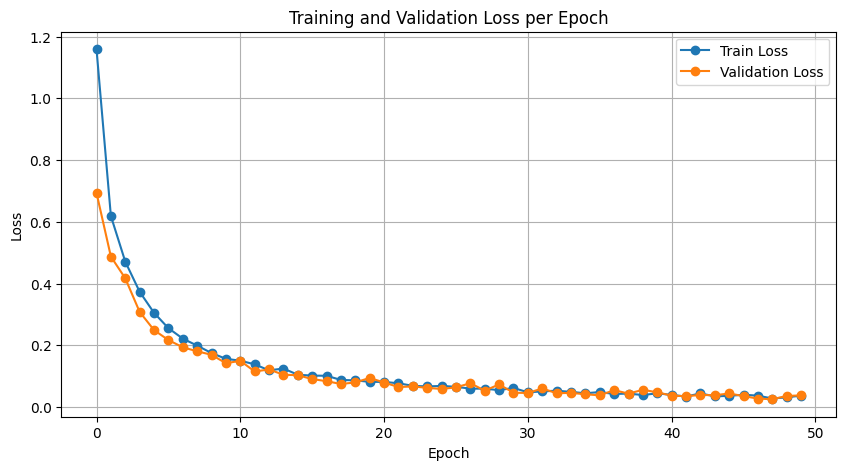

In [11]:
# -----------------------------------------------------------------------------
# 10. Loss Graph Visualization
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# -----------------------------------------------------------------------------
# 11. Self Drive Assist Function (Go/Stop Logic)
# -----------------------------------------------------------------------------
import torchvision.ops as ops

def self_drive_assist(image_path):
    # 1. 모델 평가 모드 전환
    model.eval()
    
    # 학습시 사용한 입력 크기
    input_size = (384, 1280) 
    
    # 2. 이미지 로드 및 예외처리
    if not os.path.exists(image_path):
        return "Error: File not found"
        
    original_image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = original_image.size
    
    # 3. 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # (C, H, W) -> (1, C, H, W) 배치 차원 추가 및 GPU 이동
    image_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # 4. 모델 추론
    with torch.no_grad():
        pred_box, pred_cls = model(image_tensor)
        
    # 5. 결과 디코딩 (Offsets -> Boxes)
    anchor_box_gen = AnchorBox()
    anchors = anchor_box_gen.get_anchors(input_size[0], input_size[1]).to(device)
    
    # 박스 좌표 변환 (cx, cy, w, h)
    decoded_boxes = decode_box(anchors, pred_box[0]) 
    
    # 점수 및 라벨 추출 (Sigmoid 적용)
    pred_prob = torch.sigmoid(pred_cls[0])
    scores, labels = torch.max(pred_prob, dim=1)
    
    # 6. 점수 기반 필터링 (Score Threshold > 0.5)
    mask = scores > 0.5
    filtered_boxes = decoded_boxes[mask]
    filtered_scores = scores[mask]
    filtered_labels = labels[mask]
    
    # 감지된 객체가 없으면 바로 Go
    if len(filtered_boxes) == 0:
        return "Go"
    
    # 7. NMS 적용 (중복 박스 제거)
    # NMS는 (x1, y1, x2, y2) 포맷을 사용하므로 변환
    boxes_corners = convert_to_corners(filtered_boxes)
    keep_indices = ops.nms(boxes_corners, filtered_scores, iou_threshold=0.5)
    
    final_boxes = filtered_boxes[keep_indices]
    final_labels = filtered_labels[keep_indices]
    
    # 8. 원본 이미지 크기로 박스 리스케일링 (300px 조건 확인을 위해 필수)
    scale_x = orig_w / input_size[1]
    scale_y = orig_h / input_size[0]
    
    # cx, cy, w, h 스케일링
    # 특히 w(인덱스 2), h(인덱스 3)가 중요함
    final_boxes[:, 0] *= scale_x
    final_boxes[:, 1] *= scale_y
    final_boxes[:, 2] *= scale_x 
    final_boxes[:, 3] *= scale_y 
    
    # 9. Go / Stop 판단 로직 구현
    # KITTI Class ID: 
    # Car:0, Van:1, Truck:2, Pedestrian:3, Person_sitting:4, Cyclist:5, Tram:6, Misc:7
    
    person_classes = [3, 4]       # 사람 관련 클래스
    vehicle_classes = [0, 1, 2, 6] # 차량 관련 클래스
    
    # 모든 검출된 객체에 대해 검사
    for box, label in zip(final_boxes, final_labels):
        cls_id = int(label.item())
        w = box[2].item()
        h = box[3].item()
        
        # 조건 1: 사람이 감지된 경우 -> 무조건 STOP
        if cls_id in person_classes:
            return "Stop"
            
        # 조건 2: 차량이 감지되었는데, 너비나 높이가 300px 이상인 경우 (가까움) -> STOP
        if cls_id in vehicle_classes:
            if w >= 300 or h >= 300:
                return "Stop"
    
    # 위 위험 요소가 하나도 발견되지 않으면 GO
    return "Go"

In [13]:
# -----------------------------------------------------------------------------
# 12. System Test
# -----------------------------------------------------------------------------
import os

def test_system(func):
    # 데이터 경로 설정
    work_dir = './data'
    
    # (선택사항) 만약 위 경로에 데이터가 없다면, 현재 경로의 'data' 폴더 등을 사용하도록 수정하세요.
    # if not os.path.exists(work_dir): work_dir = './data'
    
    score = 0
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]

    print(f"Testing in directory: {work_dir}")
    
    for image_file, answer in test_set:
        image_path = os.path.join(work_dir, image_file)
        
        # 예측 수행
        pred = func(image_path)
        
        # 결과 출력
        print(f"Image: {image_file} | Pred: {pred} | Answer: {answer}")
        
        if pred == answer:
            score += 10
            
    print(f"\n최종 점수: {score}점입니다.")

# 테스트 실행
test_system(self_drive_assist)

Testing in directory: ./data
Image: stop_1.png | Pred: Stop | Answer: Stop
Image: stop_2.png | Pred: Stop | Answer: Stop
Image: stop_3.png | Pred: Go | Answer: Stop
Image: stop_4.png | Pred: Stop | Answer: Stop
Image: stop_5.png | Pred: Stop | Answer: Stop
Image: go_1.png | Pred: Go | Answer: Go
Image: go_2.png | Pred: Go | Answer: Go
Image: go_3.png | Pred: Go | Answer: Go
Image: go_4.png | Pred: Go | Answer: Go
Image: go_5.png | Pred: Go | Answer: Go

최종 점수: 90점입니다.


Visualizing Stop Case...


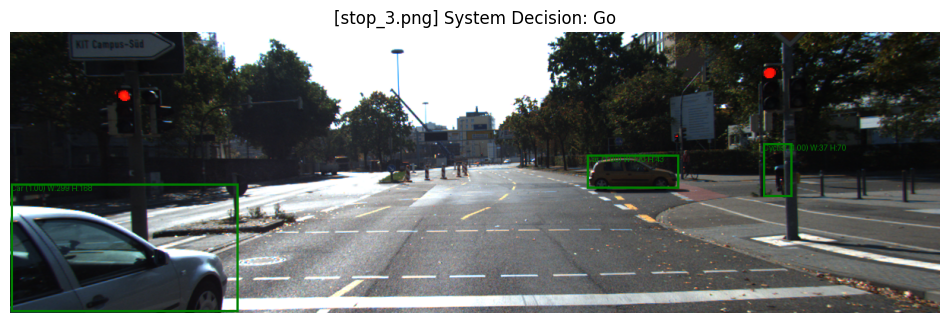

Visualizing Go Case...


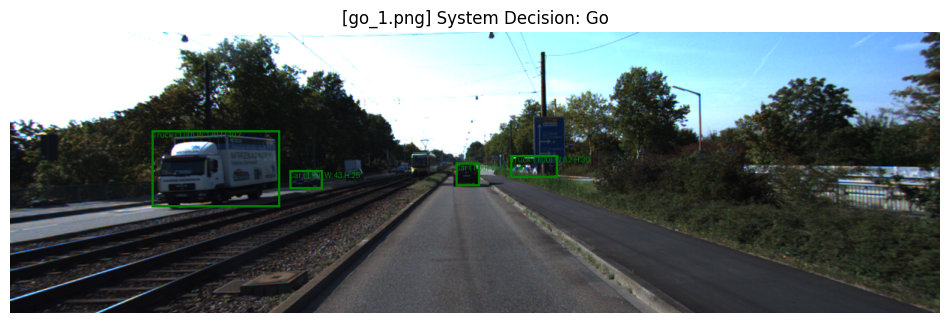

In [15]:
# -----------------------------------------------------------------------------
# 13. Detection Visualization (Stop_1 & Go_1)
# -----------------------------------------------------------------------------
def visualize_detection(image_path):
    # 1. 모델 평가 모드
    model.eval()
    input_size = (384, 1280)
    
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return

    # 2. 이미지 로드
    original_image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = original_image.size
    
    # 3. 전처리
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # 4. 추론
    with torch.no_grad():
        pred_box, pred_cls = model(image_tensor)
        
    # 5. 디코딩 & 필터링
    anchor_box_gen = AnchorBox()
    anchors = anchor_box_gen.get_anchors(input_size[0], input_size[1]).to(device)
    decoded_boxes = decode_box(anchors, pred_box[0])
    
    pred_prob = torch.sigmoid(pred_cls[0])
    scores, labels = torch.max(pred_prob, dim=1)
    
    # Score Threshold 0.5
    mask = scores > 0.5
    filtered_boxes = decoded_boxes[mask]
    filtered_scores = scores[mask]
    filtered_labels = labels[mask]
    
    # NMS 적용
    if len(filtered_boxes) > 0:
        boxes_corners = convert_to_corners(filtered_boxes)
        keep_indices = ops.nms(boxes_corners, filtered_scores, iou_threshold=0.5)
        final_boxes = filtered_boxes[keep_indices]
        final_scores = filtered_scores[keep_indices]
        final_labels = filtered_labels[keep_indices]
    else:
        final_boxes = []
        final_labels = []

    # 6. 시각화 (그리기)
    draw = ImageDraw.Draw(original_image)
    
    # 스케일링 팩터
    scale_x = orig_w / input_size[1]
    scale_y = orig_h / input_size[0]
    
    # 클래스 이름 맵 (KITTI)
    class_map_inv = {0: 'Car', 1: 'Van', 2: 'Truck', 3: 'Pedestrian', 
                     4: 'Person_sitting', 5: 'Cyclist', 6: 'Tram', 7: 'Misc'}
    
    # 판별 로직 변수
    decision = "Go"
    person_classes = [3, 4]
    vehicle_classes = [0, 1, 2, 6]

    if len(final_boxes) > 0:
        for box, label, score in zip(final_boxes, final_labels, final_scores):
            # 좌표 복원
            cx, cy, w, h = box
            cx *= scale_x; cy *= scale_y
            w *= scale_x; h *= scale_y
            
            x1 = cx - w/2
            y1 = cy - h/2
            x2 = cx + w/2
            y2 = cy + h/2
            
            cls_id = int(label.item())
            cls_name = class_map_inv.get(cls_id, str(cls_id))
            
            # Go/Stop 판단 조건 확인 (박스 색상 변경용)
            color = "green"
            is_danger = False
            
            # 조건 1: 사람
            if cls_id in person_classes:
                is_danger = True
            # 조건 2: 가까운 차량 (300px 이상)
            elif cls_id in vehicle_classes:
                if w >= 300 or h >= 300:
                    is_danger = True
            
            if is_danger:
                decision = "Stop"
                color = "red"
            
            # 박스 그리기
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            # 텍스트 그리기 (클래스명, 점수, 너비/높이)
            text = f"{cls_name} ({score:.2f}) W:{int(w)} H:{int(h)}"
            draw.text((x1, y1), text, fill=color)

    # 7. 이미지 출력
    plt.figure(figsize=(12, 6))
    plt.imshow(original_image)
    plt.title(f"[{os.path.basename(image_path)}] System Decision: {decision}")
    plt.axis('off')
    plt.show()

# 실행 (stop_1.png 과 go_1.png 확인)
print("Visualizing Stop Case...")
visualize_detection('./data/stop_3.png')

print("Visualizing Go Case...")
visualize_detection('./data/go_1.png')